# EDA & Preprocessing for Regression Dataset

## Setup & Imports

In [63]:
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.style  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from bagging_boosting_stacking_study.data.loaders import load_dataset

# dark theme across plots
pio.templates.default = "plotly_dark"
plt.style.use("dark_background")

SEED = 333

## 1. Load Data

In [64]:
df = load_dataset("california_housing")
display(df.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [65]:
# Short description of dataset
housing = fetch_california_housing(as_frame=True)

print(housing.DESCR) 

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

## 2. Initial Data Inspection

In [66]:
# Summary of dataset dimensions
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Overview of each column’s data type and counts of non-null entries
print("\nDataFrame info:")
df.info()

# Missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
if missing_values.sum() == 0:
    print("No missing values found.")
else:
    display(missing_values[missing_values > 0])

# Check for duplicated rows
duplicated_rows = df.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicated_rows}")

Dataset contains 20640 rows and 9 columns.

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB

Missing Values:
No missing values found.

Number of duplicated rows: 0


## 3. Univariate Descriptions

In [67]:
# Stats like: mean, std, min, max and quartiles for numeric columns

desc_stats = df.describe().T
display(desc_stats)

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
target,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


In [68]:
# Skewness and kurtosis
skewness = df.skew()
kurtosis = df.kurtosis()

iqr_outlier_counts = {}
z_outlier_counts = {}
outlier_index_info = {}

# Detect outliers per column
for col in df.columns:
    series = df[col]

    # IQR-based outliers
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    iqr_mask = (series < lower) | (series > upper)
    iqr_indices = series.index[iqr_mask].tolist()
    iqr_outlier_counts[col] = len(iqr_indices)

    # Z-score-based outliers (|z| > 3)
    mean, std = series.mean(), series.std()
    z_scores = (series - mean) / std
    z_mask = np.abs(z_scores) > 3
    z_indices = series.index[z_mask].tolist()
    z_outlier_counts[col] = len(z_indices)

    # Index details
    outlier_index_info[col] = {
        "iqr_indices": iqr_indices,
        "z_indices": z_indices
    }

# Summary df
summary_df = pd.DataFrame({
    "skewness": skewness,
    "kurtosis": kurtosis,
    "iqr_outliers": pd.Series(iqr_outlier_counts),
    "z_outliers": pd.Series(z_outlier_counts)
}).round(2)

# Display summary
print("Skewness, Kurtosis & Outlier Counts:\n")
display(summary_df)

Skewness, Kurtosis & Outlier Counts:



,skewness,kurtosis,iqr_outliers,z_outliers
MedInc,1.65,4.95,681,345
HouseAge,0.06,-0.80,0,0
AveRooms,20.70,879.35,511,133
AveBedrms,31.32,1636.71,1424,145
Population,4.94,73.55,1196,342
AveOccup,97.64,10651.01,711,8
Latitude,0.47,-1.12,0,0
Longitude,-0.30,-1.33,0,0
target,0.98,0.33,1071,0


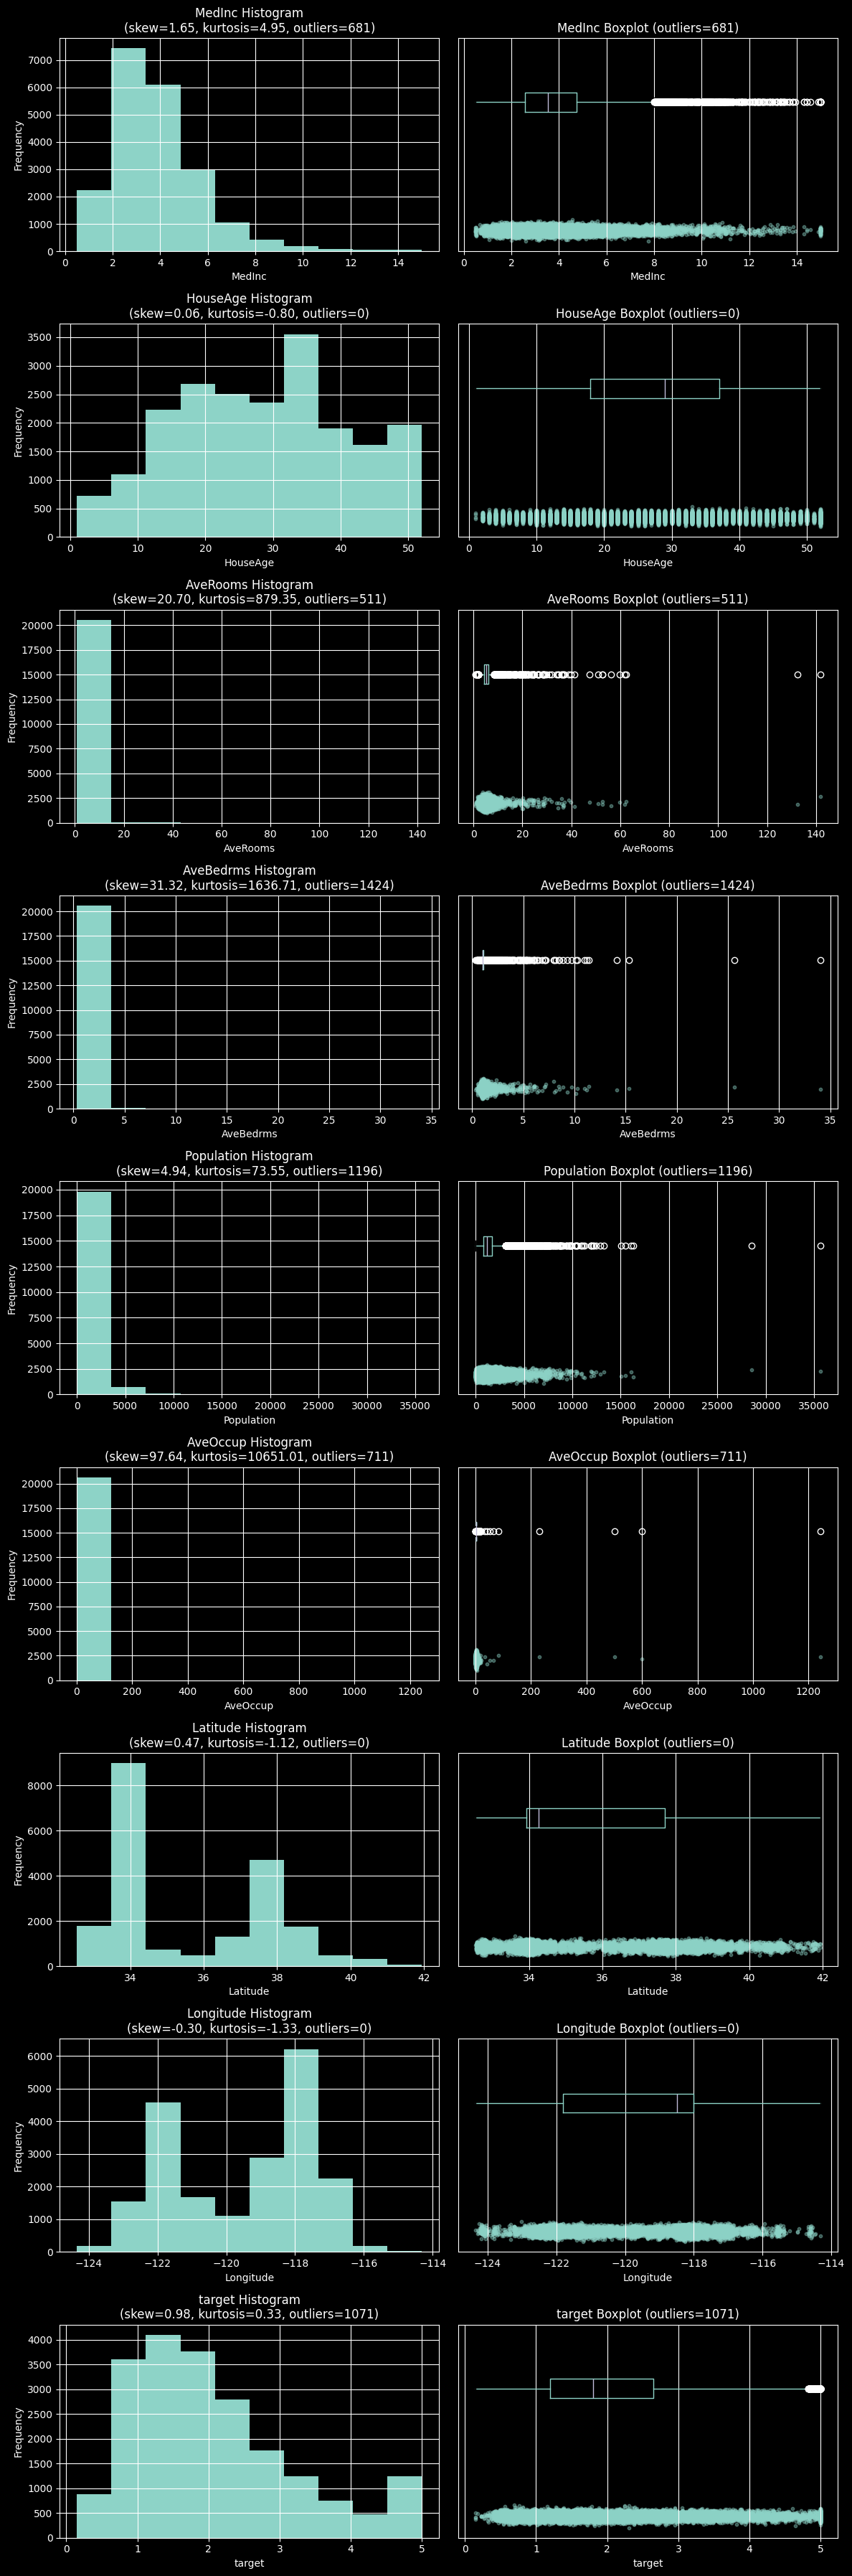

In [69]:
features = list(df.columns)
n = len(features)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n))

for i, col in enumerate(features):
    skew_val  = skewness[col]
    kurt_val  = kurtosis[col]
    out_count = iqr_outlier_counts[col]

    # Histogram with skewness & kurtosis
    ax_hist = axes[i, 0]
    df[col].hist(ax=ax_hist)
    ax_hist.set_title(
        f"{col} Histogram\n"
        f"(skew={skew_val:.2f}, kurtosis={kurt_val:.2f}, outliers={out_count})"
    )
    ax_hist.set_xlabel(col)
    ax_hist.set_ylabel("Frequency")

    # Boxplot + jitter
    ax_box = axes[i, 1]
    df.boxplot(column=col, ax=ax_box, vert=False, showfliers=True)
    y_jitter = np.random.normal(loc=0, scale=0.02, size=len(df))
    ax_box.scatter(df[col], y_jitter, alpha=0.4, s=10)
    ax_box.set_title(f"{col} Boxplot (outliers={out_count})")
    ax_box.set_xlabel(col)
    ax_box.set_yticks([])

plt.tight_layout()
plt.show()

### Distributions of features & Outliers  

- **Strong right skew & extreme outliers**  
  - **AveRooms** (skew≈20.7) & **AveBedrms** (skew≈31.3) have a handful of very large values—boxplots show long tails well above typical room counts.  
  - **AveOccup** (skew≈97.6) & **Population** (skew≈4.9) also exhibit extreme upper‐end outliers (e.g., blocks with very high occupancy or huge populations).

- **Approximately symmetric**  
  - **HouseAge** (skew≈0.06), **Latitude** (skew≈0.47) and **Longitude** (skew≈–0.30) are fairly balanced, with only moderate spread.

- **Moderate right skew**  
  - **MedInc** (skew≈1.65) and **target** (skew≈0.98) lean right but lack the extreme outliers seen elsewhere.

---

### Target Variable 

- **Range**: 0.15 – 5.00  
- **Central tendency**:  
  - Mean ≈ 2.07  
  - Median ≈ 1.80  
- **Shape**:  
  - Unimodal, with most values between 1.0–3.0  
  - Slight right‐leaning tail (longer toward higher values)  
  - Mildly heavy‐tailed (kurtosis≈0.33), but not multimodal

---

### Categorical / Discrete Features  

This dataset contains only numeric features; there are no true categorical columns.  

- **Discrete‐valued**:  
  - **HouseAge** is integer‐valued (1–52 years) but well distributed.  
  - **Latitude** & **Longitude** cluster by region but remain continuous.  

## 4. Outlier & Missing-Value Analysis

In [70]:
# Missing values
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

In [71]:
# Outliers
display(summary_df["iqr_outliers"])

MedInc         681
HouseAge         0
AveRooms       511
AveBedrms     1424
Population    1196
AveOccup       711
Latitude         0
Longitude        0
target        1071
Name: iqr_outliers, dtype: int64

### Interpretation

- **MedInc (681 outliers)**  
  A moderate number (~4.5% of the data) of extreme low/high income blocks—plausible given income variability.

- **HouseAge (0 outliers)**  
  No extreme values beyond 1.5 × IQR—consistent with a fairly uniform distribution of housing ages.

- **AveRooms & AveBedrms (511 & 1424 outliers)**  
  Substantial outliers, especially in bedrooms where some blocks have very high room-to-bedroom ratios—likely real but extreme cases (e.g., large estates or vacation homes).

- **Population (1196 outliers)**  
  Many blocks with very high populations—reflecting dense urban areas versus rural blocks.

To sum up those rows flagged by IQR or Z-score are **valid** observations, reflecting real block‐group extremes rather than data entry errors.
Therefore, we **do not need to drop** them for correctness—but ywe may choose to cap, transform, or flag them in our pipeline (especially with sensitive meta-learner) to improve stability and interpretability.

---

### Conclusions

**Tree-based Methods (Bagging, Boosting)**  
   - Robust to outliers; we can generally leave these extreme values in place, as tree ensembles won’t be overly skewed by them.

**Stacking with a Sensitive Meta-learner**  
   - We will consider combining these 3 methods to achieve best results:  
     - **Winsorizing** (capping) at the 1st/99th percentiles.  
     - **Log1p-transforming** `Population`, `AveRooms`, and `AveBedrms` to compress long tails.  
     - **Adding outlier-flag features** (binary indicators) so the meta-learner can account for extremes explicitly.

## 5. Correlation Analysis

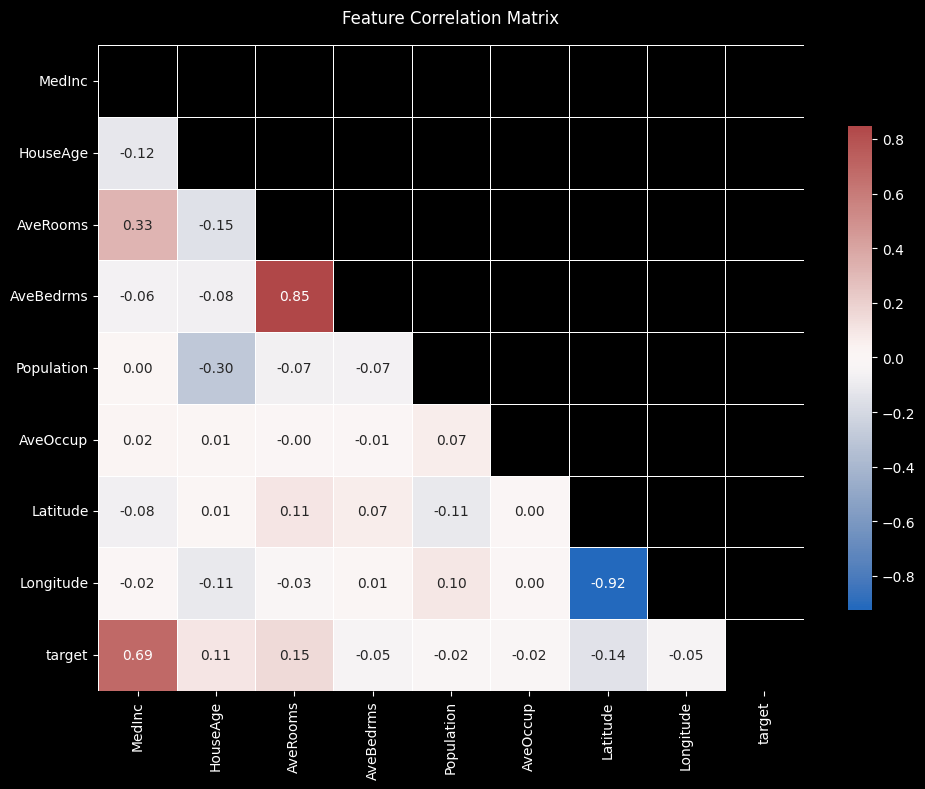

In [72]:
# Correlation matrix
corr = df.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    ax=ax
)

ax.set_title("Feature Correlation Matrix", color="white", pad=16)
plt.tight_layout()
plt.show()

## Key Relationships from correlation matrix

| Pair                       | Corr.  | Interpretation                                               |
|:---------------------------|-------:|:-------------------------------------------------------------|
| **MedInc ↔ target**        |  **0.69**  | Higher median income areas tend to have higher house values. |
| **AveRooms ↔ AveBedrms**   |  **0.85**  | Average rooms and average bedrooms per household are nearly collinear—drop or combine one. |
| **Latitude ↔ Longitude**   | **–0.92**  | Geographic cluster: as you move north, you tend to move west (negative longitude).  |
| **Population ↔ AveOccup**  |   0.07  | Very weak positive: denser blocks only slightly higher occupancy. |
| **HouseAge ↔ any**         | ~0.0–0.15| Essentially uncorrelated with most other features.            |
| **Other pairs**            | <│0.35│ | Most remaining feature pairs show only mild correlations.     |

## Strategy for Handling Highly Correlated Features

When two features exhibit near-perfect correlation, we combine them via PCA into a single, uncorrelated component. This preserves their joint information while avoiding multicollinearity issues in linear meta-learner.

---

### Latitude & Longitude → **Geo1**

- **Issue:** Latitude and Longitude are strongly negatively correlated (r≈–0.92), reflecting California’s northwest–southeast orientation.  
- **Solution:** Apply PCA to merge them into one feature, **Geo1**, which captures the primary spatial gradient.  
- **Benefit:** Removes redundancy and yields a single “geographic” variable.

---

### AveRooms & AveBedrms → **RoomsPC**

- **Issue:** Average rooms and average bedrooms per household are nearly collinear (r≈0.85), since more rooms almost always mean more bedrooms.  
- **Solution:** Use PCA to combine them into **RoomsPC**, summarizing overall household size characteristics.  
- **Benefit:** Retains >95% of the shared variance while eliminating duplicate information.

---

### Why PCA Is Ideal Here

- **Eliminates Multicollinearity:** Produces orthogonal components.  
- **Maximizes Variance Retention:** Each principal component captures the lion’s share of variability in its original pair.  
- **Simplifies Modeling:** Reduces feature count without substantive information loss.

---

### Implementation Notes

- Perform PCA **after** any outlier-handling to ensure component directions reflect the transformed distributions.  



## 6. Multivariate Exploration

In [73]:
# 1. Compute correlation matrix and identify top correlated features with target
corr_matrix = df.corr()
target_corr = corr_matrix['target'].drop('target').abs().sort_values(ascending=False)
top_feats = target_corr.head(4).index.tolist()

print("Top features correlated with target:")
print(target_corr.head())

Top features correlated with target:
MedInc       0.688075
AveRooms     0.151948
Latitude     0.144160
HouseAge     0.105623
AveBedrms    0.046701
Name: target, dtype: float64


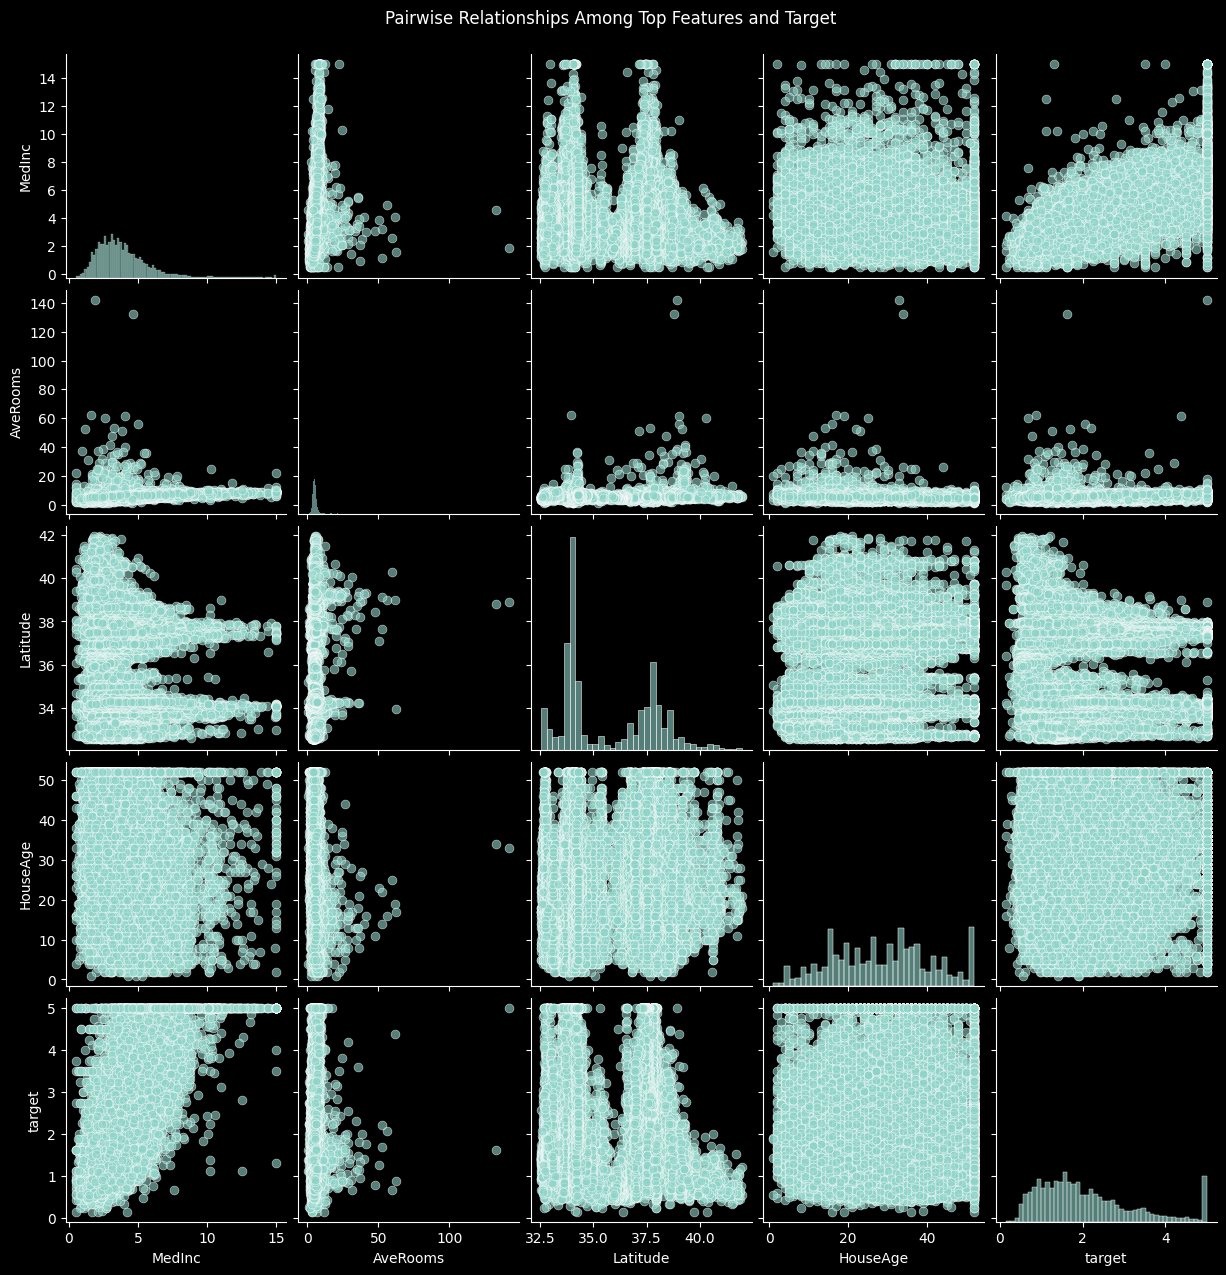

In [74]:
# Create pairplot
sns.pairplot(
    df[top_feats + ['target']],
    kind="scatter",
    diag_kind="hist",
    plot_kws={"alpha": 0.6, "s": 40, "edgecolor": "white"},
    diag_kws={"alpha": 0.6}
)

plt.suptitle("Pairwise Relationships Among Top Features and Target", y=1.02)
plt.show()

## Interpretation of Pairwise Relationships

### 1. MedInc vs. AveRooms  
- **Shape**: A cloud with a gentle upward tilt—higher-income block groups tend to have slightly more rooms per household.  
- **Clusters/Outliers**: Dense cluster at low incomes & low room counts; a few outliers with very high room counts but mixed incomes.

### 2. MedInc vs. Latitude  
- **Shape**: Nearly uniform scatter—no strong latitudinal gradient in income.  
- **Subtle Trend**: Slight dip in income at the highest latitudes (far north), but overall weak correlation.

### 3. MedInc vs. HouseAge  
- **Shape**: Broad band with a very mild downward slope—older housing areas skew toward lower incomes.  
- **Noise**: Wide vertical spread indicates many exceptions (new/old homes in both wealthy and modest areas).

### 4. AveRooms vs. Latitude  
- **Shape**: Vertical “stripes” at discrete latitude values (due to rounded coordinates), but no clear linear trend.  
- **Insight**: Room counts vary similarly across all latitudes—roominess isn’t region-specific.

### 5. AveRooms vs. HouseAge  
- **Shape**: Slight negative tilt—newer homes (higher HouseAge value) have modestly fewer rooms on average, but very weak.  
- **Scatter**: Overlap everywhere, so age alone doesn’t predict household size.

### 6. Latitude vs. HouseAge  
- **Shape**: Near-random cloud—house age is distributed evenly across north–south.  
- **Conclusion**: No meaningful geographic clustering by age at the block-group level.

---

### Features vs. Target

- **MedInc vs. Target**  
  - **Strong linear** positive relationship (r≈0.69).  
  - **Interpretation**: Higher incomes reliably predict higher median home values—our single best predictor.

- **AveRooms vs. Target**  
  - **Moderate positive** trend: more rooms correlate with higher value, but with broad variance—room size alone is not definitive.

- **Latitude vs. Target**  
  - **Slight negative** trend: southern/coastal (lower latitude) areas tend to be more expensive, but effect is weak (r≈–0.14).

- **HouseAge vs. Target**  
  - **Minimal** relationship (r≈0.11): both new and old neighborhoods span the full price range.

---

## Key Takeaways

1. **MedInc** is clearly the strongest linear predictor of **target**.  
2. **AveRooms** adds some signal but with diminishing returns—many mid-room counts map to a wide span of prices.  
3. **Latitude** and **HouseAge** individually have little to no linear effect on **target**, though they may interact with other features in non-linear models.  
4. **Discrete latitude stripes** suggest clustering by region (consider region encoding or PCA on coords).    


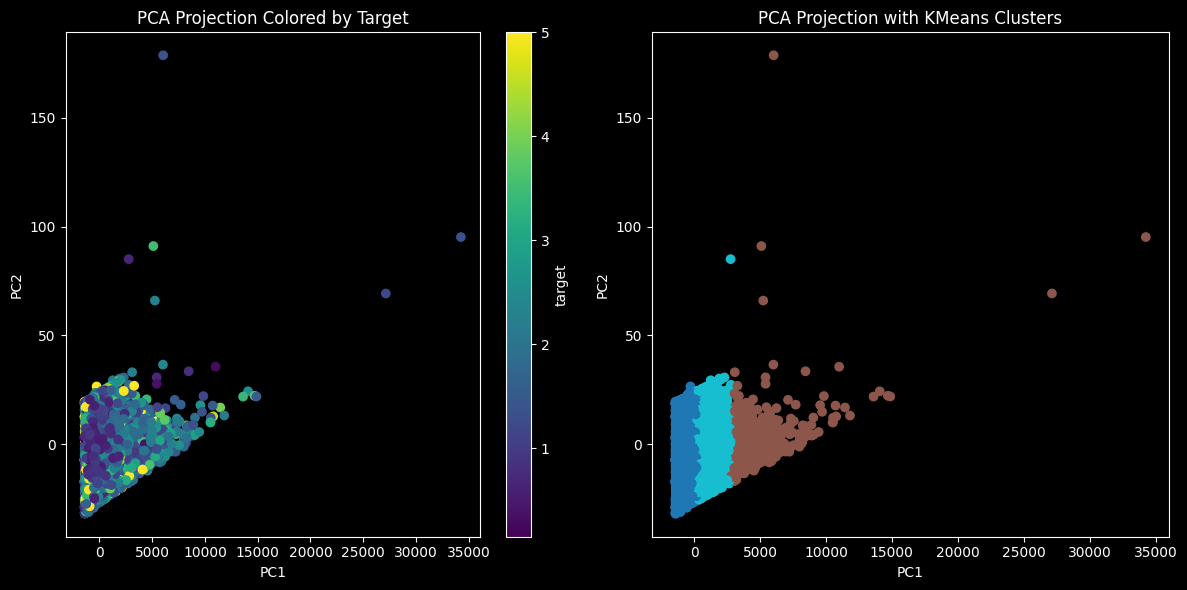

In [75]:
# 1. PCA projection to 2D
X = df.drop(columns=['target'])
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X)

# 2. KMeans clustering on PCA space
labels = KMeans(n_clusters=3, random_state=42).fit_predict(proj)

# 3. Create 1x2 grid for the two plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot A: PCA colored by target
sc = axes[0].scatter(proj[:, 0], proj[:, 1], alpha=1, c=df['target'])
axes[0].set_title("PCA Projection Colored by Target")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
fig.colorbar(sc, ax=axes[0], label='target')

# Plot B: PCA with KMeans clusters
axes[1].scatter(proj[:, 0], proj[:, 1], alpha=1, c=labels, cmap='tab10')
axes[1].set_title("PCA Projection with KMeans Clusters")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()

## Interpretation of PCA Projections

### 1. PCA Projection Colored by Target  

- **PC1 (horizontal)** captures the major share of variance, driven primarily by high-range features like **Population**, **AveRooms**, and **AveBedrms**.  
- **PC2 (vertical)** captures secondary variance, influenced by occupancy ratios and a few extreme, high-leverage outliers.  
- **Main cluster**: Most block-groups reside in the dense core at PC1≈0–5000 & PC2≈–20–20, indicating moderate population/room counts with typical occupancy.  
- **House‐value gradient**:  
  - `target` values (yellow = high, purple = low) are **mixed** within the core, with a slight shift of higher-value points toward **upper PC2**.  
  - This suggests that while income and room counts dominate PC1, **occupancy/bedroom patterns** (PC2) also play a role in distinguishing high-value neighborhoods.  
- **Outliers**: A handful of points lie far right (PC1>20 000) or high (PC2>150); these correspond to very large or unusual blocks (e.g. dense urban centers or huge estates). Their `target` values vary widely, so size alone doesn’t guarantee high value.

### 2. PCA Projection with KMeans Clusters  

- **Three clusters** emerge along the PC1 axis:  
  1. **Cluster A (low PC1)**: Rural/low-density blocks (small populations, few rooms).  
  2. **Cluster B (mid PC1)**: Suburban/mid-density neighborhoods.  
  3. **Cluster C (high PC1)**: Urban/high-density centers and extreme outliers.  
- **Cluster–target relationship**:  
  - **Cluster A** is dominated by **lower** median house values.  
  - **Cluster B** spans a **wide** range of values, including many of the **highest** `target` points—ideal for capturing “sweet-spot” suburbs.  
  - **Cluster C** contains both low and high values, indicating that very large blocks can be either expensive (downtown) or cheap (oversized rural parcels).  

- **Actionable insight**: We could **stratify** our models by these clusters—e.g. train separate regressors for rural, suburban, and urban segments to capture their distinct value dynamics.

---

### Overall Takeaways

- **PC1 vs. PC2** reveals that **population/room scale** is the strongest axis of variation, with **occupancy** providing a secondary split.  
- **House values** are **not** strictly a function of scale; they cluster modestly along PC2 and within the suburban cluster (B).  
- **KMeans** on the PCA embedding uncovers interpretable **density-based segments** that may improve model performance when used for stratified training or as additional categorical features.  


## 7. Feature Engineering Plan

### 1. Transformations  
- **Log1p (or power) transforms** on heavy­tails:  
  - `Population`, `AveRooms`, `AveBedrms` → `log1p(x)`  
  - *Rationale:* Compresses long right tails, makes distribution more symmetric and stabilizes variance for linear models and gradient‐based splits.  
- **Robust scaling** (median & IQR) on all numeric features (after any log/winsorize steps)  
  - *Rationale:* Brings all features to comparable scale without being distorted by remaining outliers—especially important for distance‐based and regularized methods.  

---

### 2. Derived Features  
- **PCA components**  
  - `Geo1` = PC1(Latitude, Longitude)  
  - `RoomsPC` = PC1(AveRooms, AveBedrms)  
  - *Rationale:* Removes multicollinearity and summarizes geography & household composition in one axis.  
- **Interactions & polynomials**  
  - `MedInc × RoomsPC` or `MedInc²`  
  - *Rationale:* Captures non-linear payoff of income on home value and room-income synergies.   
- **Aggregate or density metrics**  
  - `Population / AveOccup` → “household density”  
  - *Rationale:* Encodes how crowded a block group is, may differentiate urban/suburban patterns.

---

### 3. Categorical & Rare-Level Encoding  
- **KMeans “Region” clusters** on PCA embedding → one-hot encode 3–5 clusters  
  - *Rationale:* Captures latent geographic segments (rural vs. urban vs. suburban) that both tree and linear models can leverage.  
- **Binned age/income** → ordinal encode (0,1,2,3) or one-hot  
  - *Rationale:* Enables models to treat bins as categorical splits or linear steps.  
- **Rare-level grouping**  
  - If binning yields a level <2% frequency, label as “Other”  
  - *Rationale:* Prevents overfitting to tiny segments and keeps feature dimensionality manageable.

## 8. Preprocessing Pipeline Outline

## 1. Outlier Handling  
- **Primary:** Log1p-transform heavily skewed features (`Population`, `AveRooms`, `AveBedrms`)  
- **Secondary:** Winsorize each at the 1st and 99th percentiles  
- **Optional:** Add binary “outlier flag” columns for these same features  

---

## 2. Correlated Feature Reduction (PCA)  
- **Latitude & Longitude → Geo1** (1st principal component)  
- **AveRooms & AveBedrms → RoomsPC** (1st principal component)  
- **Drop** the original paired columns  

---

## 3. Derived Features  
- **Interactions & Polynomials**  
  - `MedInc × RoomsPC`  
  - `MedInc²`  
- **Binning**  
  - `HouseAge` → 4 age groups (e.g. new, young, mature, historic)  
  - `MedInc` → quartile bands  
- **Density Metric**  
  - `HouseholdDensity = Population / AveOccup`  

---

## 4. Unsupervised Segment Features  
- **KMeans Clustering** on the 2-D PCA embedding (all features) into 3–5 “Region” clusters  
- **One-hot encode** the cluster labels  

---

## 5. Scaling & Normalization  
- **RobustScaler** (median & IQR) on all numeric features **after** log/winsorize  
- Ensures comparable scales without being distorted by residual outliers  

---

## 6. Final Feature Set Assembly  
- **Drop** raw skewed and collinear columns:  
  - `Population`, `AveRooms`, `AveBedrms`, `Latitude`, `Longitude`  
- **Include**:  
  - Transformed & scaled features  
  - PCA components (`Geo1`, `RoomsPC`)  
  - Outlier flags  
  - Interaction/polynomial features  
  - Binned & one-hot features  
  - KMeans region dummies  